In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import Point
from sympy.abc import alpha
#%matplotlib notebook

In [18]:
start_time = pd.Timestamp('2025-10-08 18:00:00')
df1 = pd.read_csv('../outputs/pipeline_run/tracks_video_3_24fps.csv')
df2 = pd.read_csv('../outputs/pipeline_run/tracks_video_4_24fps.csv')
df2['frame'] = df1['frame'].max() + 2 + df2['frame']
df2['tracker_id'] = df2['tracker_id'] + df1['tracker_id'].max()
df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined['second'] = df_combined['frame'] / 24
df_combined['timestamp'] = start_time + pd.to_timedelta(df_combined['second'], unit='s')
df_track = df_combined.drop(
    columns=['x_min', 'x_max', 'y_min', 'y_max', 'class_id', 'confidence', 'class_name', 'frame', 'second'])
alina_data = alina_data = pd.read_csv('../data/alina_data.csv', parse_dates=['timestamp'])
df_track

,tracker_id,lv95_E,lv95_N,timestamp
0,1,2680856.5,1248087.4,2025-10-08 18:00:00.000
1,2,2680842.8,1248096.2,2025-10-08 18:00:00.000
2,3,2680875.8,1248074.6,2025-10-08 18:00:00.000
3,4,2680826.5,1248106.8,2025-10-08 18:00:00.000
4,5,2680849.8,1248092.2,2025-10-08 18:00:00.000
...,...,...,...,...
300322,7295,2680848.5,1248092.0,2025-10-08 18:43:49.250
300323,7321,2680837.2,1248099.5,2025-10-08 18:43:49.250
300324,7373,2680827.0,1248106.2,2025-10-08 18:43:49.250
300325,7086,2680872.0,1248074.6,2025-10-08 18:43:49.250


In [19]:
lane = gpd.read_file("../data/lane.geojson").to_crs("EPSG:2056")
geom = lane.geometry.iloc[0]
L = geom.length

In [20]:
gpts = gpd.GeoSeries([Point(xy) for xy in df_track[["lv95_E", "lv95_N"]].to_numpy()], crs=2056)

df_track["s_m"] = gpts.apply(geom.project)

gpts = gpd.GeoSeries([Point(xy) for xy in alina_data[["lv95_E", "lv95_N"]].to_numpy()], crs=2056)
alina_data["s_m"] = gpts.apply(geom.project)

df_track["s_norm"] = df_track["s_m"] / L
alina_data["s_norm"] = df_track["s_m"] / L

In [21]:
# Sort properly
df_track = df_track.sort_values(["tracker_id", "timestamp"])

# Compute per-vehicle speed [m/s] using finite differences
df_track["v_mps"] = (
        df_track.groupby("tracker_id")["s_m"].diff() /
        df_track.groupby("tracker_id")["timestamp"].diff().dt.total_seconds()
)

# Remove NaNs or unrealistic values
df_track["v_mps"] = df_track["v_mps"].clip(lower=0, upper=np.ceil(50 / 3.6))
df_track["v_kph"] = df_track["v_mps"] * 3.6

In [22]:
df_track.to_csv('../data/track_data.csv')

In [23]:
# --- parameters ---
dt = "30s"  # time bin size
# choose a spatial segment; use whole lane or a subsegment
s_lo, s_hi = 0.0, L  # or e.g. (L/2 - 50, L/2 + 50) for a 100 m segment
L_seg = float(s_hi - s_lo)
T_bin = pd.to_timedelta(dt).total_seconds()

# --- build per-vehicle intervals ---
g = df_track.copy()
g["timestamp"] = pd.to_datetime(g["timestamp"])
g = g.sort_values(["tracker_id", "timestamp"])

g["t_prev"] = g.groupby("tracker_id")["timestamp"].shift()
g["s_prev"] = g.groupby("tracker_id")["s_m"].shift()

g["dt"] = (g["timestamp"] - g["t_prev"]).dt.total_seconds()
g["ds"] = g["s_m"] - g["s_prev"]

# interval midpoints
g["t_mid"] = g["t_prev"] + pd.to_timedelta(g["dt"] / 2, unit="s")
g["s_mid"] = g["s_prev"] + g["ds"] / 2

# keep valid intervals (positive dt, reasonable speeds)
g = g[(g["dt"] > 0)]
g["v_mps"] = g["ds"] / g["dt"]
g = g[(g["v_mps"].abs() < 60)]  # cap |v| < 216 km/h; allow both directions if needed

# restrict to spatial segment via midpoint test (Edie rectangle)
g = g[(g["s_mid"] >= s_lo) & (g["s_mid"] < s_hi)].copy()

# --- aggregate per time bin (Edie averages) ---
# sum of time present and distance traveled for intervals whose midpoint is in the bin
edie = (
    g.set_index("t_mid")
    .groupby(pd.Grouper(freq=dt))
    .agg(
        tau_sum_s=("dt", "sum"),  # total vehicle-seconds inside rectangle
        dist_sum_m=("ds", lambda x: x.abs().sum()),  # total meters traveled inside rectangle
    )
)

# normalize by rectangle size |A| = L_seg * T_bin
edie["k_veh_per_m"] = edie["tau_sum_s"] / (L_seg * T_bin)
edie["q_veh_per_s"] = edie["dist_sum_m"] / (L_seg * T_bin)

# friendly units
edie["density_veh_km"] = edie["k_veh_per_m"] * 1000.0
edie["flow_veh_h"] = edie["q_veh_per_s"] * 3600.0
# space-mean speed (and consistent with q = k*v)
edie["mean_speed_mps"] = np.where(edie["tau_sum_s"] > 0, edie["dist_sum_m"] / edie["tau_sum_s"], np.nan)
edie["mean_speed_kmh"] = edie["mean_speed_mps"] * 3.6

# Optionally keep just the main outputs
edie_out = edie[["flow_veh_h", "density_veh_km", "mean_speed_kmh"]]
edie_out

,flow_veh_h,density_veh_km,mean_speed_kmh
t_mid,,,
2025-10-08 18:00:00,43.800382,21.087457,2.077082
2025-10-08 18:00:30,61.326933,20.518487,2.988862
2025-10-08 18:01:00,42.386312,21.234779,1.996080
2025-10-08 18:01:30,37.847440,20.376244,1.857430
2025-10-08 18:02:00,40.388967,22.708006,1.778622
...,...,...,...
2025-10-08 18:41:30,36.705515,10.094140,3.636319
2025-10-08 18:42:00,24.379913,11.049197,2.206487
2025-10-08 18:42:30,18.155480,15.219952,1.192874


In [24]:
edie_out.mean()

flow_veh_h        43.465015
density_veh_km    17.135666
mean_speed_kmh     2.623233
dtype: float64

In [25]:
edie_out.std()

flow_veh_h        19.046593
density_veh_km     4.131076
mean_speed_kmh     1.159259
dtype: float64

In [26]:
print(edie_out.describe().to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrr}
\toprule
 & flow_veh_h & density_veh_km & mean_speed_kmh \\
\midrule
count & 88.00 & 88.00 & 88.00 \\
mean & 43.47 & 17.14 & 2.62 \\
std & 19.05 & 4.13 & 1.16 \\
min & 4.75 & 7.37 & 0.26 \\
25% & 29.71 & 14.14 & 1.84 \\
50% & 39.54 & 17.65 & 2.38 \\
75% & 54.24 & 19.75 & 3.35 \\
max & 107.95 & 27.20 & 6.31 \\
\bottomrule
\end{tabular}



In [27]:
alina_df = pd.read_csv('../data/edie_alina.csv', parse_dates=True)
alina_df['t_mid'] = pd.to_datetime(alina_df['t_mid'])
alina_df = alina_df.set_index('t_mid')
alina_df

,flow_veh_h,density_veh_km,mean_speed_kmh
t_mid,,,
2025-10-06 18:00:00,61.090562,18.845105,3.241721
2025-10-06 18:00:30,59.225910,10.383706,5.703736
2025-10-06 18:01:00,55.161571,12.972520,4.252186
2025-10-06 18:01:30,46.091565,20.344747,2.265527
2025-10-06 18:02:00,28.175361,18.979219,1.484537
...,...,...,...
2025-10-06 18:42:30,52.368469,22.185772,2.360453
2025-10-06 18:43:00,26.068649,21.925672,1.188956
2025-10-06 18:43:30,53.386817,20.104967,2.655404


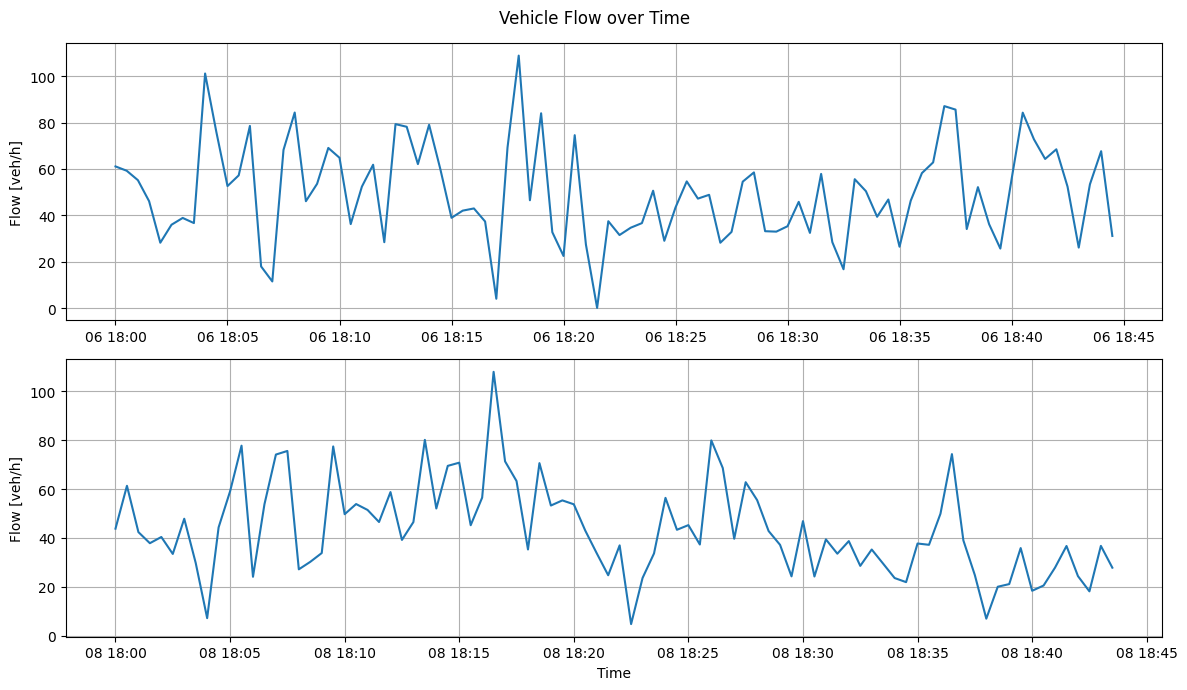

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
ax[0].plot(alina_df['flow_veh_h'])
ax[1].plot(edie_out['flow_veh_h'])
ax[0].grid()
ax[1].grid()
ax[0].set_ylabel('Flow [veh/h]')
ax[1].set_ylabel('Flow [veh/h]')
ax[1].set_xlabel('Time')
fig.suptitle('Vehicle Flow over Time')
plt.tight_layout()
plt.savefig('../outputs/plots/vehicle_flow.pdf', dpi=300)
plt.show()

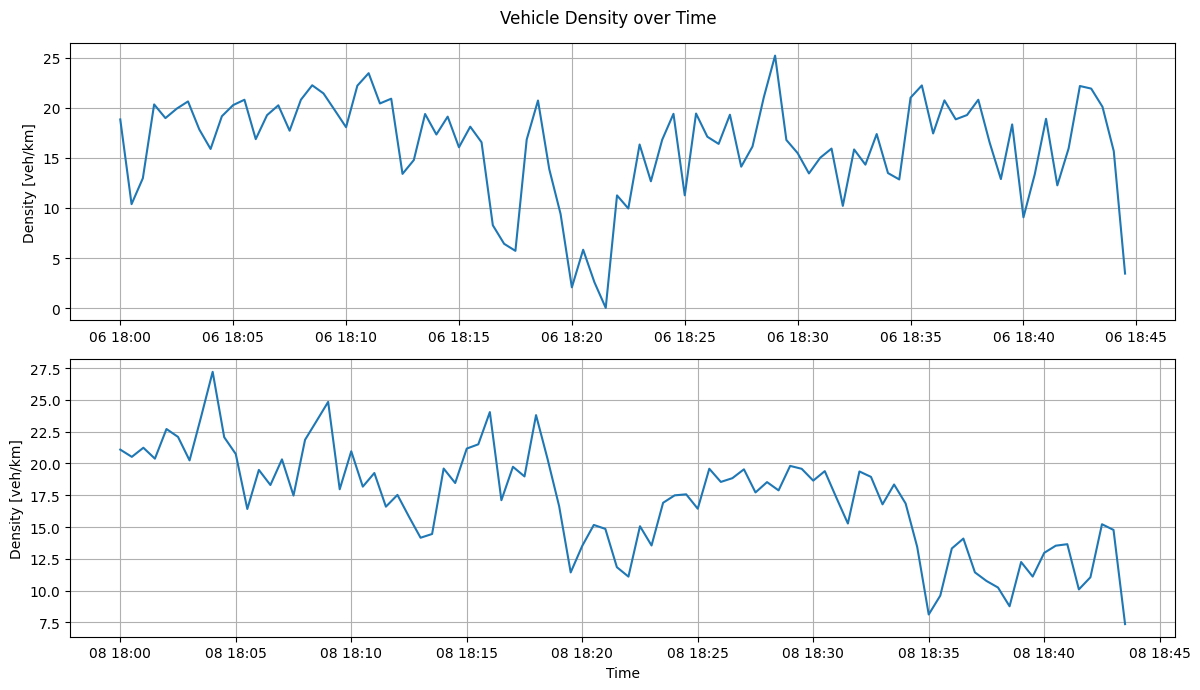

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
ax[0].plot(alina_df['density_veh_km'])
ax[1].plot(edie_out['density_veh_km'])
ax[0].grid()
ax[1].grid()
ax[0].set_ylabel('Density [veh/km]')
ax[1].set_ylabel('Density [veh/km]')
ax[1].set_xlabel('Time')
fig.suptitle('Vehicle Density over Time')
plt.tight_layout()
plt.savefig('../outputs/plots/vehicle_density.pdf', dpi=300)
plt.show()

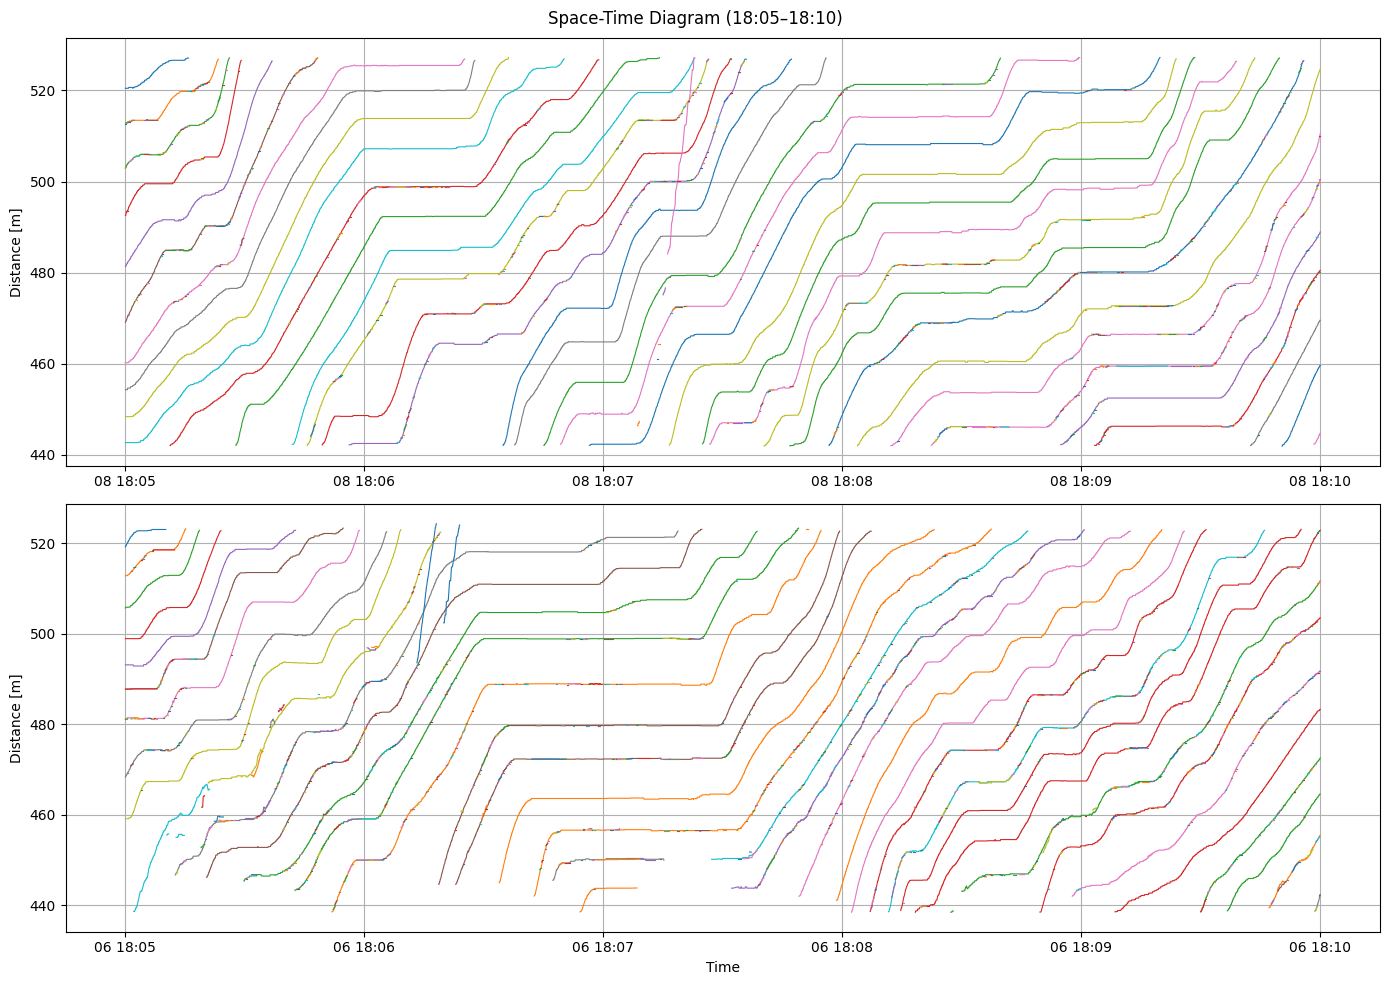

In [31]:
import datetime as dt

# Define the time range
start_time = dt.time(18, 5)
end_time = dt.time(18, 10)

# Filter both dataframes based on time only
df_track_filtered = df_track[df_track['timestamp'].dt.time.between(start_time, end_time)]
alina_data_filtered = alina_data[alina_data['timestamp'].dt.time.between(start_time, end_time)]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Upper plot: df_track
for tid, group in df_track_filtered.groupby('tracker_id'):
    axes[0].plot(group['timestamp'], group['s_m'], linewidth=0.8)
axes[0].set_ylabel('Distance [m]')
axes[0].grid()

# Lower plot: alina_data
for tid, group in alina_data_filtered.groupby('tracker_id'):
    axes[1].plot(group['timestamp'], group['s_m'], linewidth=0.8)
axes[1].set_ylabel('Distance [m]')
axes[1].set_xlabel('Time')
axes[1].grid()

fig.suptitle('Space-Time Diagram (18:05–18:10)')
plt.tight_layout()
plt.savefig('../outputs/plots/space_time_diagram_1805_1810.png', dpi=300)
plt.show()

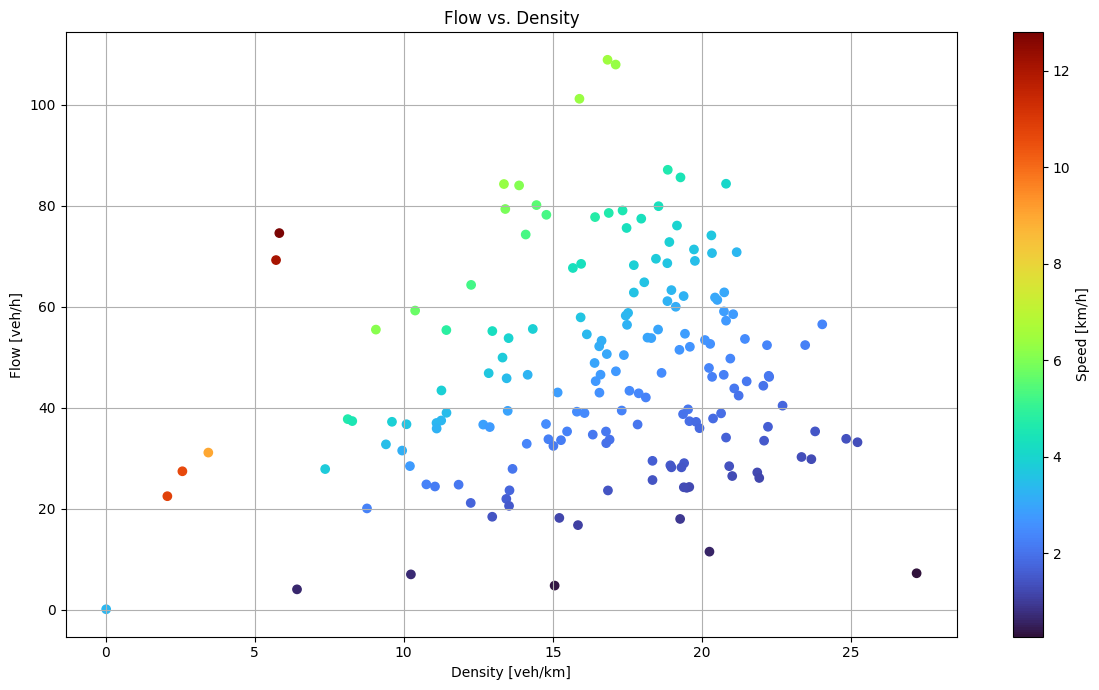

In [24]:
df = pd.concat([edie_out, alina_df])

fig = plt.figure(figsize=(12, 7))
sc = plt.scatter(df['density_veh_km'], df['flow_veh_h'], c=df['mean_speed_kmh'], cmap='turbo')
plt.xlabel('Density [veh/km]')
plt.ylabel('Flow [veh/h]')
plt.title('Flow vs. Density')
plt.colorbar(sc, label='Speed [km/h]')
plt.grid()
plt.tight_layout()
plt.savefig('../outputs/plots/flow_density_scatter.pdf', dpi=300)
plt.show()

In [43]:
print(df.describe().to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrr}
\toprule
 & flow_veh_h & density_veh_km & mean_speed_kmh \\
\midrule
count & 178.00 & 178.00 & 178.00 \\
mean & 46.57 & 16.64 & 3.08 \\
std & 20.20 & 4.66 & 1.88 \\
min & 0.07 & 0.02 & 0.26 \\
25% & 33.01 & 13.71 & 2.00 \\
50% & 44.07 & 17.46 & 2.78 \\
75% & 58.69 & 19.80 & 3.64 \\
max & 108.89 & 27.20 & 12.79 \\
\bottomrule
\end{tabular}

